In [88]:
%matplotlib inline

import matplotlib.pyplot as plt
import pysam
import seaborn as sns
from operator import itemgetter
from collections import defaultdict, Counter
import pandas as pd
import re
from sequencing_tools.bam_tools import concordant_alignment, cigar_to_str

plt.rc('axes', labelsize=15)
plt.rc('xtick', labelsize =15)
plt.rc('ytick', labelsize = 15)

In [89]:
bed_file = '/stor/work/Lambowitz/cdw2854/cell_Free_nucleotides/tgirt_map/merged_bam/filtered_bam/unfragmented.protein_sense.bed'
splice_finder = re.compile('[0-9]+N')
bases_finder = re.compile('[0-9]+')

isize_dict = defaultdict(lambda: defaultdict(int))
for bed_line in open(bed_file):
    fields = bed_line.strip().split('\t')
    start, end, cigars = itemgetter(1,2,-1)(fields)
    frag_size = int(end) - int(start)
    spliced = splice_finder.findall(cigars)
    label = 'Not spliced'
    if spliced and len(spliced)==1:
        label = 'Spliced'
        bases = set()
        for splice in spliced:
            bases.add(int(bases_finder.search(splice).group(0)))
        frag_size -= sum(bases)
        if frag_size < 0:
            print(bases, frag_size, int(end) - int(start), bed_line)
    
    isize_dict[label][frag_size] += 1

In [92]:
dfs = []
for label, label_df in isize_dict.items():
    dfs.append(pd.DataFrame({'isize': list(label_df.keys()),
                 'isize_count': list(label_df.values())}) \
        .assign(label = label))
df = pd.concat(dfs) \
    .sort_values('isize')\
    .query('isize < 500')\
    .assign(fraction = lambda d: d.groupby('label').isize_count.transform(lambda x: 100 * x/x.sum()))\


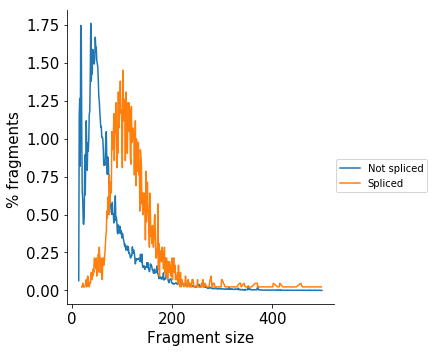

In [94]:
p = sns.FacetGrid(data = df.sort_values('isize'), 
                  hue = 'label',
                 size=5)
p.map(plt.plot, 'isize', 'fraction')
p.add_legend(title = '')
p.set_axis_labels('Fragment size', '% fragments ')

In [66]:
df

,isize,isize_count,label
0,159,329222,Not spliced
0,159,8625,Spliced
